In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
import numpy as np
import sys
import cv2
import os

sys.path.append("..")

from bodypose.training.metrics import avgMDE_2D, avgMDE_2D_RAW, Accuracy
from bodypose.training.metrics import RegressionLoss2D, AuxiliaryLoss
from bodypose.training.preprocessing import load_TFRecords_dataset  
from bodypose.training.preprocessing import augmentations
from bodypose.training.architecture import MoveNet
from bodypose.demo.graphics import draw_keypoints
from bodypose.training.architecture.custom_layers import get_max_mask

import config as cfg

In [2]:
INPUT_SHAPE = (224, 224, 3)
STRIDES = (32, 16, 8, 4)
NUM_KPTS = len(cfg.MPII_KEYPOINT_DICT)

GRID_SIZE = INPUT_SHAPE[0] // STRIDES[-1]

In [3]:
filePaths = list(paths.list_files("../dataset/tfrecords/mpii/validation/"))
print(f"[INFO] Found {len(filePaths)} TFRecords.")

ds = load_TFRecords_dataset(
    filePaths=filePaths, 
    batch_size = 1,
    target_size = INPUT_SHAPE[:2],
    grid_dim = GRID_SIZE,
    augmentations = [],
    roi_thresh = 0.9
    )

[INFO] Found 10 TFRecords.


2022-11-04 16:08:12.877675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model = MoveNet(
    input_shape = INPUT_SHAPE, 
    strides = STRIDES, 
    num_joints = NUM_KPTS, 
    alpha = .25, 
    use_depthwise = True,
    debug=True
    )

img = (np.random.uniform(
    0, 255, (1,) + INPUT_SHAPE
    ).astype("uint8") / 255).astype(np.float32)

%timeit model(img)

128 ms ± 7.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
for img, (y1, y2) in ds.take(1):
    kpts, heatmaps, w_heatmaps = model(img)
    kpts = kpts[0].numpy()
    heatmaps  = heatmaps[0].numpy()

print(kpts)

[[0.03894329 0.36607143 0.544645   0.49969622 0.49986932]
 [0.03895235 0.6696438  0.40178457 0.5003268  0.4997951 ]
 [0.03894221 0.31250072 0.6696455  0.49965817 0.5000811 ]
 [0.03893904 0.65178865 0.6696438  0.5001363  0.49992964]
 [0.03895375 0.3660734  0.38392848 0.49956185 0.49963045]
 [0.03894049 0.49107054 0.58035797 0.49995956 0.5000616 ]
 [0.03896985 0.52678573 0.27678698 0.5000299  0.49923715]
 [0.03893351 0.38392836 0.5446417  0.49983472 0.5001809 ]
 [0.03896254 0.6517831  0.38393024 0.5003746  0.49951863]
 [0.0389381  0.36606902 0.41963923 0.4998603  0.4997337 ]
 [0.03892235 0.31250045 0.7232157  0.49987245 0.50000674]
 [0.03894639 0.5803585  0.6339299  0.50027    0.5000449 ]
 [0.03895147 0.47321412 0.7946429  0.4999865  0.500398  ]
 [0.0389393  0.4375005  0.6339296  0.4999242  0.50010586]
 [0.03894994 0.6696424  0.580357   0.5004089  0.5001378 ]
 [0.03893016 0.27678677 0.49107233 0.49976322 0.4999108 ]]


1/1 [==============================] - 2s 2s/step


Text(0.5, 1.0, 'Weighted Keypointsmap')

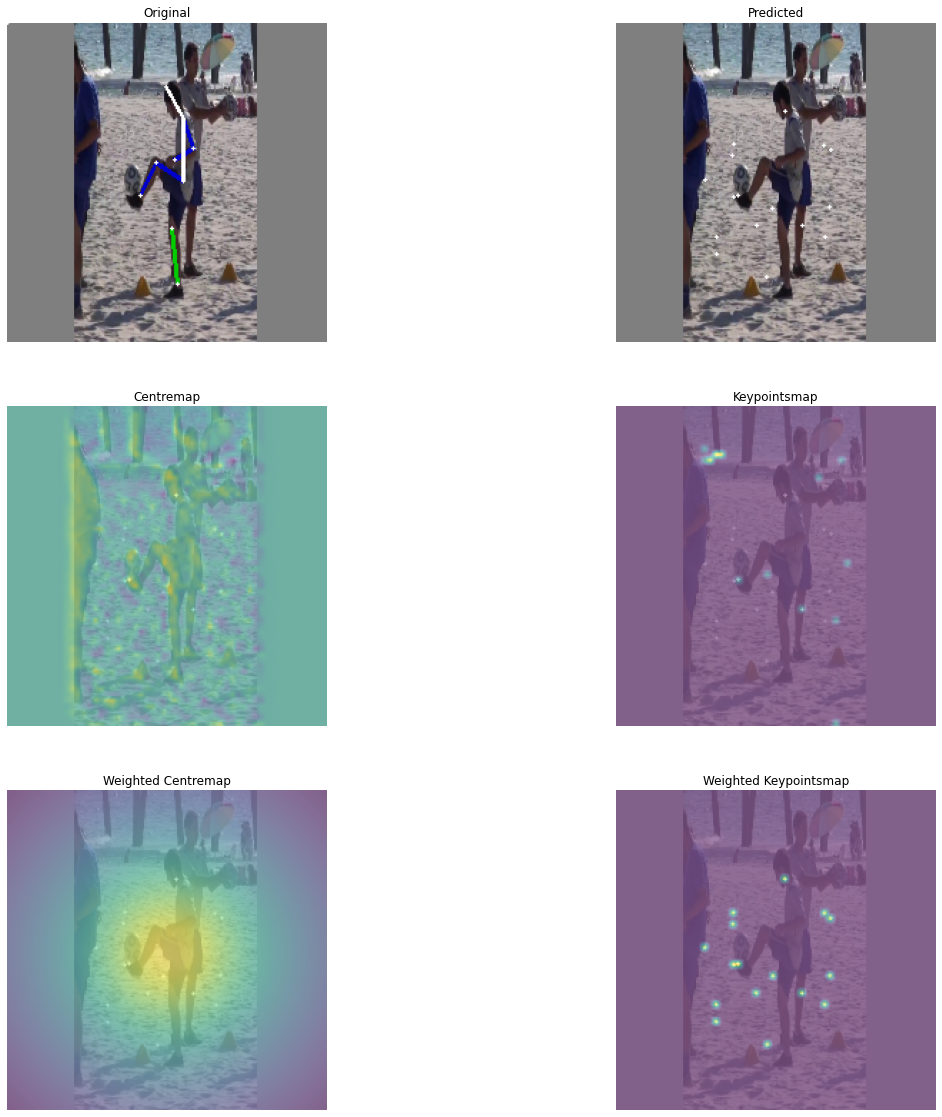

In [6]:

i=0
pred_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()
true_img = ((img[i].numpy() + 1) * 127.5).astype('uint8').copy()

preds, heatmaps, w_heatmaps = model.predict(img[i:i+1])
preds = preds[0, :, :3]
preds = preds[:, [1,2,0]]

# Heatmaps
kptsmask = get_max_mask(heatmaps.reshape(-1, 56, 56, NUM_KPTS+1))
kptsmap = kptsmask[0, :, :, 1:].numpy().sum(axis=-1)
kptsmap = cv2.resize(kptsmap, INPUT_SHAPE[:2])

centremap = heatmaps[0, :, 0].reshape(56, 56)
centremap = cv2.resize(centremap, INPUT_SHAPE[:2])

# Weighted heatmaps
w_kptsmask = get_max_mask(w_heatmaps.reshape(-1, 56, 56, NUM_KPTS+1))
w_kptsmap = w_kptsmask[0, :, :, 1:].numpy().sum(axis=-1)
w_kptsmap = cv2.resize(w_kptsmap, INPUT_SHAPE[:2])

w_centremap = w_heatmaps[0, :, 0].reshape(56, 56)
w_centremap = cv2.resize(w_centremap, INPUT_SHAPE[:2])


labels = y1[i, :, :3].numpy()
labels = labels[:, [1,2,0]]

pred_img = draw_keypoints(pred_img, preds, .5, cfg.MPII_KEYPOINT_DICT)
true_img = draw_keypoints(true_img, labels, .5, cfg.MPII_KEYPOINT_DICT)

fig, axs = plt.subplots(3, 2)
fig.set_figheight(20)
fig.set_figwidth(20)

axs[0,0].imshow(true_img)
axs[0,0].axis('off')
axs[0,0].set_title("Original")

axs[0,1].imshow(pred_img)
axs[0,1].axis('off')
axs[0,1].set_title("Predicted")

axs[1,0].imshow(pred_img, alpha=.5)
axs[1,0].imshow(centremap,  alpha=.5)
axs[1,0].axis('off')
axs[1,0].set_title("Centremap")

axs[1,1].imshow(pred_img, alpha=.5)
axs[1,1].imshow(kptsmap,  alpha=.5)
axs[1,1].axis('off')
axs[1,1].set_title("Keypointsmap")

axs[2,0].imshow(pred_img, alpha=.5)
axs[2,0].imshow(w_centremap,  alpha=.5)
axs[2,0].axis('off')
axs[2,0].set_title("Weighted Centremap")

axs[2,1].imshow(pred_img, alpha=.5)
axs[2,1].imshow(w_kptsmap,  alpha=.5)
axs[2,1].axis('off')
axs[2,1].set_title("Weighted Keypointsmap")